In [2]:
import pandas as pd
temperature_data = pd.read_excel("Testdaten.xlsx")

In [81]:
temperature_data_modified = temperature_data[['timestamp_new', 'temperature']]
temperature_data_modified['timestamp_new'] = pd.to_datetime(temperature_data_modified['timestamp_new'], errors='coerce')
temperature_data_modified = temperature_data_modified.groupby([temperature_data_modified["timestamp_new"].dt.month, temperature_data_modified["timestamp_new"].dt.day, temperature_data_modified["timestamp_new"].dt.hour]).temperature.mean()
temperature_data_modified.head()

C:\Users\nikla\AppData\Local\Temp\ipykernel_5896\2819484725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_data_modified['timestamp_new'] = pd.to_datetime(temperature_data_modified['timestamp_new'], errors='coerce')


timestamp_new  timestamp_new  timestamp_new
6              27             0                22.0
                              1                22.0
                              2                22.0
                              3                22.0
                              4                22.0
Name: temperature, dtype: float64

In [82]:
from datetime import datetime
new_list = []
for index, value in temperature_data_modified.items():
    new_dataframe_row = {'timestamp': datetime.strptime(f"2022-{index[0]}-{index[1]} {index[2]}:00:00", "%Y-%m-%d %H:%M:%S"), 'temperature': value}
    new_dataframe = new_list.append(new_dataframe_row)

In [83]:
new_dataframe = pd.DataFrame.from_records(new_list, columns=['timestamp', 'temperature'])
new_dataframe = new_dataframe.set_index('timestamp')

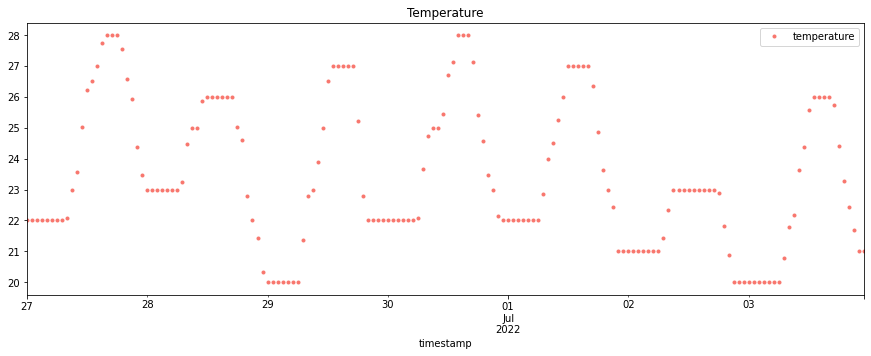

In [84]:
import matplotlib.pyplot as plt
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
new_dataframe.plot(style='.', figsize=(15,5), color=color_pal[0], title='Temperature')
plt.show()

In [85]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(new_dataframe, label='temperature')

features_and_target = pd.concat([X, y], axis=1)

C:\Users\nikla\AppData\Local\Temp\ipykernel_5896\2992744994.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [86]:
features_and_target

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,temperature
timestamp,,,,,,,,,
2022-06-27 00:00:00,0,0,2,6,2022,178,27,26,22.000000
2022-06-27 01:00:00,1,0,2,6,2022,178,27,26,22.000000
2022-06-27 02:00:00,2,0,2,6,2022,178,27,26,22.000000
2022-06-27 03:00:00,3,0,2,6,2022,178,27,26,22.000000
2022-06-27 04:00:00,4,0,2,6,2022,178,27,26,22.000000
...,...,...,...,...,...,...,...,...,...
2022-07-03 19:00:00,19,6,3,7,2022,184,3,26,23.266667
2022-07-03 20:00:00,20,6,3,7,2022,184,3,26,22.433333
2022-07-03 21:00:00,21,6,3,7,2022,184,3,26,21.700000


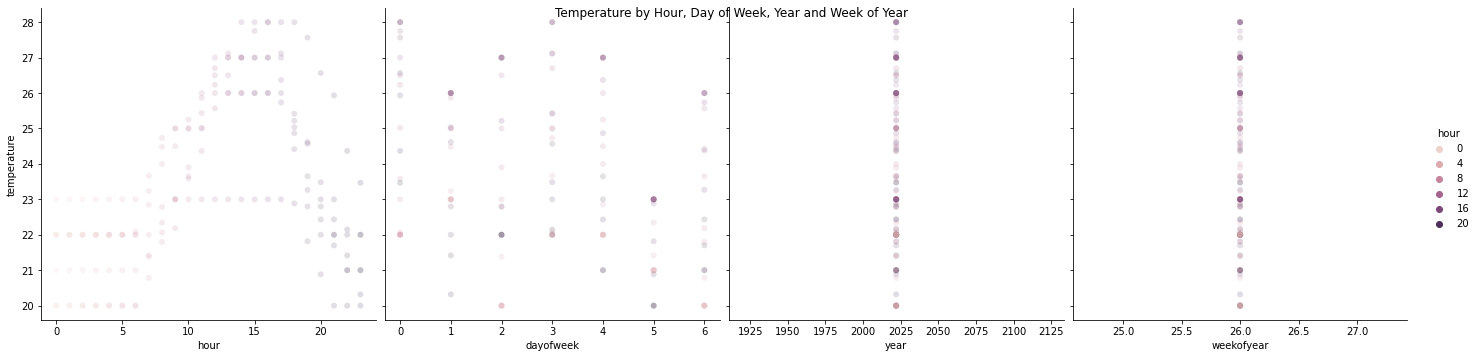

In [87]:
import seaborn as sns
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='temperature',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Temperature by Hour, Day of Week, Year and Week of Year')
plt.show()

In [88]:
split_date = '03-Jul-2022'
train_data = new_dataframe.loc[new_dataframe.index <= split_date].copy()
test_data = new_dataframe.loc[new_dataframe.index > split_date].copy()

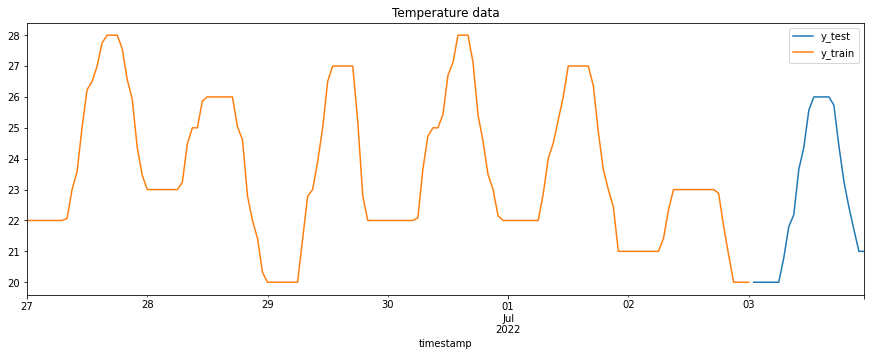

In [89]:
test_data.rename(columns={'temperature': 'y_test'}).join(train_data.rename(columns={'temperature': 'y_train'}), how="outer").plot(figsize=(15,5), title='Temperature data')
plt.show()

In [90]:
train_data.reset_index().rename(columns={'index': 'ds', 'temperature': 'y'}).head()

,timestamp,y
0,2022-06-27 00:00:00,22.0
1,2022-06-27 01:00:00,22.0
2,2022-06-27 02:00:00,22.0
3,2022-06-27 03:00:00,22.0
4,2022-06-27 04:00:00,22.0


In [91]:
from prophet import Prophet
model = Prophet()
model.fit(train_data.reset_index() \
              .rename(columns={'timestamp':'ds',
                               'temperature':'y'}))

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [92]:
prophet_test_forecast = model.predict(df=test_data.reset_index().rename(columns={'timestamp':'ds'}))

In [93]:
prophet_test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-07-03 01:00:00,20.671996,17.616328,19.571480,20.671996,20.671996,-2.040638,-2.040638,-2.040638,-2.040638,-2.040638,-2.040638,0.0,0.0,0.0,18.631358
1,2022-07-03 02:00:00,20.580634,17.523101,19.440182,20.575995,20.586411,-2.086389,-2.086389,-2.086389,-2.086389,-2.086389,-2.086389,0.0,0.0,0.0,18.494246
2,2022-07-03 03:00:00,20.489273,17.464474,19.327107,20.475441,20.505283,-2.146421,-2.146421,-2.146421,-2.146421,-2.146421,-2.146421,0.0,0.0,0.0,18.342852
3,2022-07-03 04:00:00,20.397911,17.282935,19.121611,20.372664,20.429679,-2.177727,-2.177727,-2.177727,-2.177727,-2.177727,-2.177727,0.0,0.0,0.0,18.220184
4,2022-07-03 05:00:00,20.306549,17.277367,19.114987,20.267912,20.356230,-2.091858,-2.091858,-2.091858,-2.091858,-2.091858,-2.091858,0.0,0.0,0.0,18.214691


In [61]:
model.make_future_dataframe(periods=7*24, freq="H",include_history=False)

,ds
0,2022-07-03 01:00:00
1,2022-07-03 02:00:00
2,2022-07-03 03:00:00
3,2022-07-03 04:00:00
4,2022-07-03 05:00:00
...,...
163,2022-07-09 20:00:00
164,2022-07-09 21:00:00
165,2022-07-09 22:00:00
166,2022-07-09 23:00:00


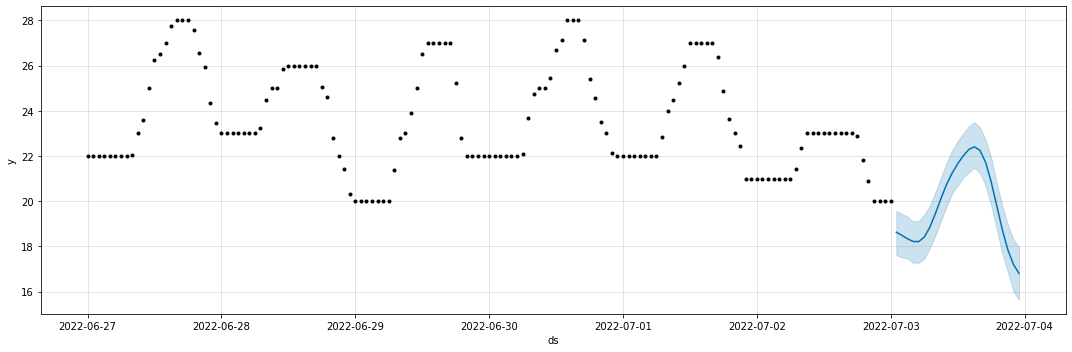

In [94]:
f, ax = plt.subplots(figsize=(15,5))
fig = model.plot(prophet_test_forecast, ax=ax)
plt.show()

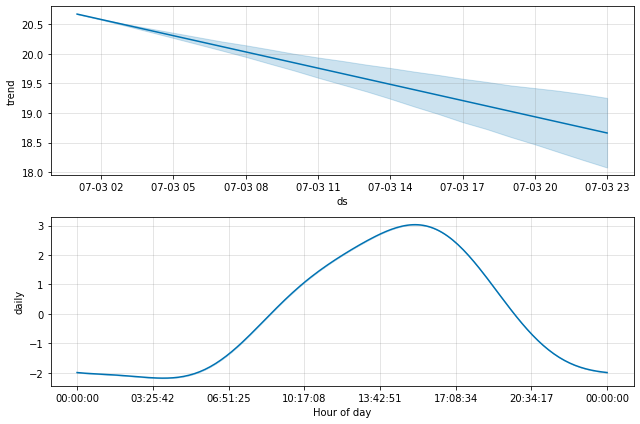

In [96]:
fig = model.plot_components(prophet_test_forecast)

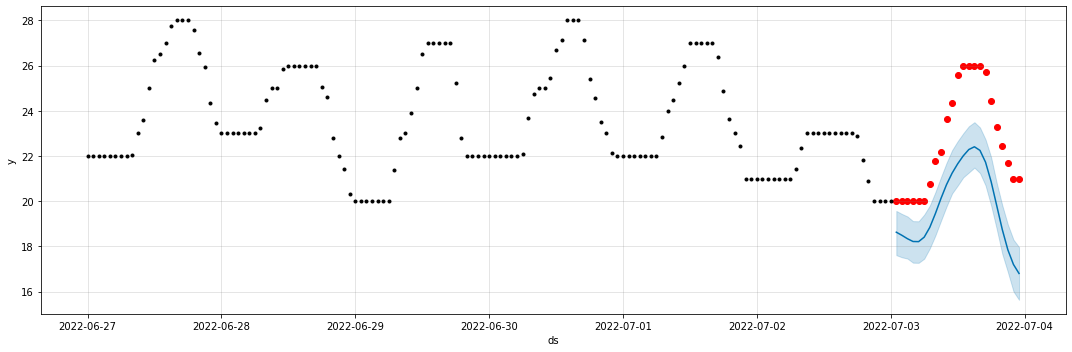

In [95]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test_data.index, test_data['temperature'], color='r')
fig = model.plot(prophet_test_forecast, ax=ax)